# Eddy Snapshots — Vorticity & Surface Speed

Snapshots of surface relative vorticity (normalised by Coriolis → Rossby number)
and surface speed at individual time steps, revealing mesoscale eddy structure.

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from gyre import (
    load_output, load_mesh, interior_mask, grid_angle,
    interp_uv_to_t, rotate_to_geo, gyre_map,
)

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load data

Load U/V velocities, T-grid coordinates, and mesh_mask (scale factors, Coriolis).

In [2]:
ds_u = load_output("*_grid_U.nc", OUTPUT_DIR)
ds_v = load_output("*_grid_V.nc", OUTPUT_DIR)
ds_t = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

angle = grid_angle(mesh)
interior = interior_mask(mesh.tmask.isel(nav_lev=0), border=2)

/gxfs_work/geomar/smomw122/2026-Claude-NEMO/analysis/gyre.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, decode_cf=False, chunks=-1)


/gxfs_work/geomar/smomw122/2026-Claude-NEMO/analysis/gyre.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, decode_cf=False, chunks=-1)


/gxfs_work/geomar/smomw122/2026-Claude-NEMO/analysis/gyre.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, decode_cf=False, chunks=-1)


## Compute surface relative vorticity

Relative vorticity ζ = ∂v/∂x − ∂u/∂y computed on Arakawa C-grid f-points:
- V lives on v-points → `diff('x')` moves to f-points
- U lives on u-points → `diff('y')` moves to f-points

Normalise by the Coriolis parameter `ff_f` to get the Rossby number ζ/f.

In [3]:
# Determine snapshot indices from the time coordinate (cheap — metadata only)
nt = ds_u.sizes["time_counter"]
snap_idx = [5, nt // 3, 2 * nt // 3, nt - 1]

# Surface velocities — load only the 4 snapshot time steps
u_sfc = ds_u["vozocrtx"].isel(nav_lev=0, time_counter=snap_idx).load()
v_sfc = ds_v["vomecrty"].isel(nav_lev=0, time_counter=snap_idx).load()

# Scale factors at f-points (squeeze out time_counter from mesh)
e1f = mesh["e1f"]
e2f = mesh["e2f"]
ff_f = mesh["ff_f"]

# Finite differences on C-grid
dvdx = v_sfc.diff("x") / e1f.isel(x=slice(None, -1))
dudy = u_sfc.diff("y") / e2f.isel(y=slice(None, -1))

# Align to common f-point grid (trim to overlapping region)
nx = min(dvdx.sizes["x"], dudy.sizes["x"])
ny = min(dvdx.sizes["y"], dudy.sizes["y"])
dvdx = dvdx.isel(x=slice(None, nx), y=slice(None, ny))
dudy = dudy.isel(x=slice(None, nx), y=slice(None, ny))

vort = dvdx - dudy

# Rossby number: ζ/f, masked to interior f-points
ff_trim = ff_f.isel(x=slice(None, nx), y=slice(None, ny))
fmask_sfc = mesh["fmask"].isel(nav_lev=0, x=slice(None, nx), y=slice(None, ny))
interior_f = interior_mask(fmask_sfc, border=2)
rossby = (vort / ff_trim).where(interior_f)

print(f"Vorticity grid: {rossby.sizes}")
print(f"Rossby number range: [{float(rossby.min()):.3f}, {float(rossby.max()):.3f}]")

Vorticity grid: Frozen({'time_counter': 4, 'y': 99, 'x': 149})
Rossby number range: [-0.597, 0.598]


## Compute surface speed per time step

In [4]:
# Interpolate to T-points so both components are co-located, then rotate
u_on_t, v_on_t = interp_uv_to_t(u_sfc, v_sfc)
u_east, v_north = rotate_to_geo(u_on_t, v_on_t, angle)
speed = np.sqrt(u_east**2 + v_north**2).where(interior).load()

## Multi-panel snapshot figure

Select time steps from early, middle, and late in the simulation.
Top row: relative vorticity (ζ/f). Bottom row: surface speed.

Saved figures/eddy_snapshots.png


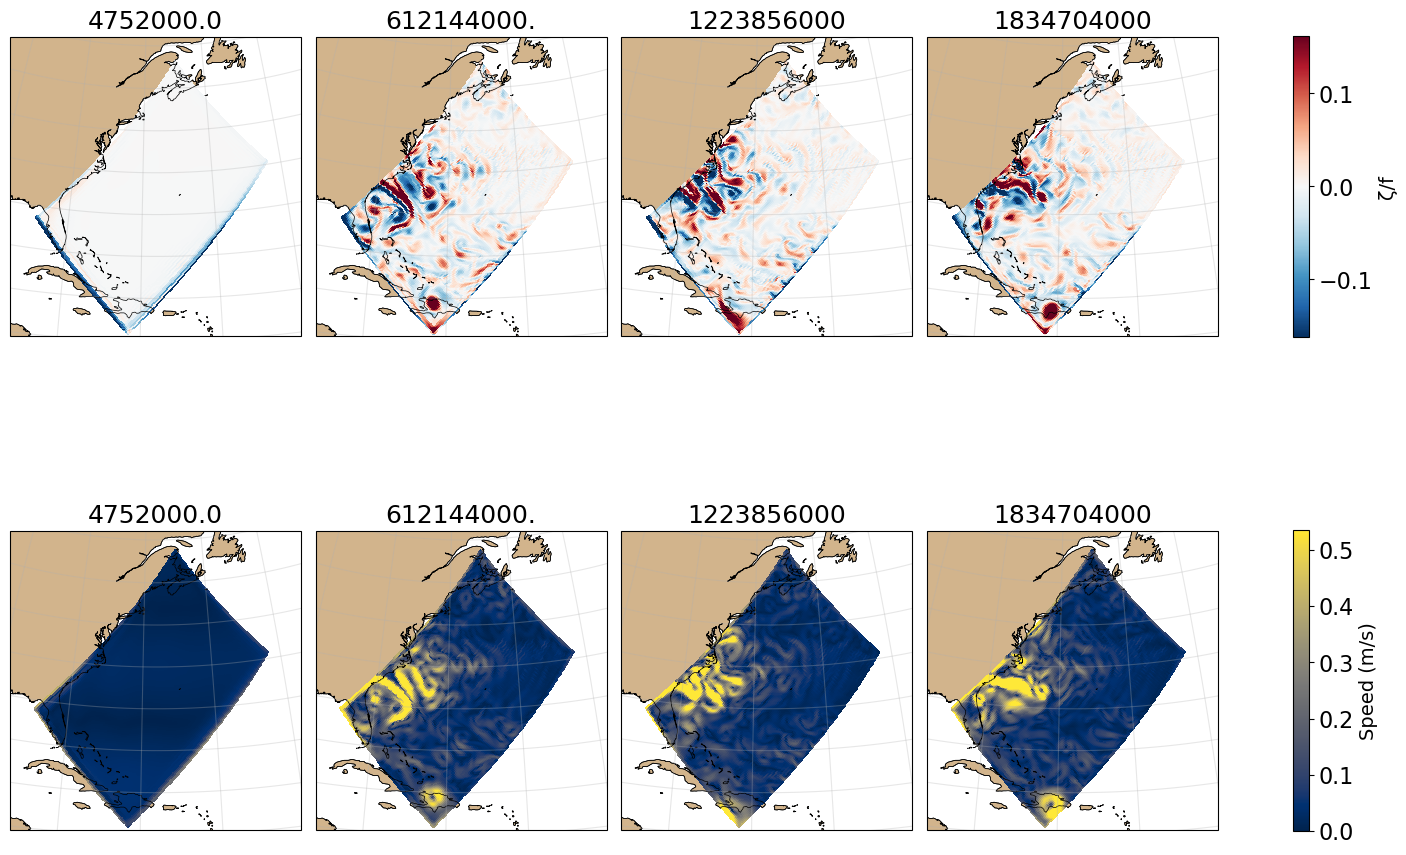

In [5]:
nsnaps = len(snap_idx)

# Coordinates for pcolormesh (use T-grid lon/lat, trimmed for vorticity)
lon_t = ds_t.nav_lon.values
lat_t = ds_t.nav_lat.values
lon_f = lon_t[:ny, :nx]
lat_f = lat_t[:ny, :nx]

# Colour limits from interior only (exclude 3-cell boundary ring)
s = dict(x=slice(3, -3), y=slice(3, -3))
ro_int = rossby.isel(**s)
spd_int = speed.isel(**s)

vmax_ro = float(np.abs(ro_int).quantile(0.98))
vmax_spd = float(spd_int.quantile(0.98))

proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
fig, axes = plt.subplots(
    2, nsnaps, figsize=(5 * nsnaps, 12),
    subplot_kw=dict(projection=proj),
)
fig.subplots_adjust(hspace=0.15, wspace=0.05, right=0.88)

for col in range(nsnaps):
    time_label = str(rossby.time_counter.values[col])[:10]

    # --- Top row: vorticity ---
    ax = axes[0, col]
    gyre_map(ax=ax, ds=ds_t)
    pcm = ax.pcolormesh(
        lon_f, lat_f,
        rossby.isel(time_counter=col).values,
        shading="auto", cmap="RdBu_r",
        vmin=-vmax_ro, vmax=vmax_ro,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(time_label)

    # --- Bottom row: speed ---
    ax = axes[1, col]
    gyre_map(ax=ax, ds=ds_t)
    pcm2 = ax.pcolormesh(
        lon_t, lat_t,
        speed.isel(time_counter=col).values,
        shading="auto", cmap="cividis",
        vmin=0, vmax=vmax_spd,
        transform=ccrs.PlateCarree(),
    )
    ax.set_title(time_label)

# Colorbars in the reserved right margin
fig.colorbar(pcm, ax=axes[0, :].tolist(), label="ζ/f", shrink=0.7)
fig.colorbar(pcm2, ax=axes[1, :].tolist(), label="Speed (m/s)", shrink=0.7)

fig.savefig("../figures/eddy_snapshots.png", dpi=150, bbox_inches="tight")
print("Saved figures/eddy_snapshots.png")